# this code to measure the time of: 
## Gaussian RF, Gaussian+Eig RF, OPU RF 

In [20]:
import grakel as gk
from grakel.utils import graph_from_networkx
from grakel.datasets import fetch_dataset
from grakel import Graph
from grakel.kernels import ShortestPath
from grakel.kernels import GraphletSampling
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from random import random
from sklearn.utils import shuffle 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import random
from abc import ABC, abstractmethod
import warnings                                     # from here on, it is from lighton
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#%matplotlib inline                                 ############################# almost not important
#from lightonml.projections.sklearn import OPUMap
#from lightonml.encoding.base import NoDecoding
#from lightonml.encoding.base import NoEncoding
from numpy import linalg as LA


'\nWe can follow Random features for large-scale kernel machines, A. Rahimi and B. Recht (2007) and \nsolve a standard ridge regression on a nonlinear mapping of the data to a new feature space of a \ndifferent dimension.\n\nWhen the number of random projections m tends to infinity, the inner product between the projected\ndata points approximates a kernel function, due to the concentration of measure (Computation with \ninfinite neural networks, C. Williams, 1998).\n\nThe matrix-vector multiplication outputs a (1×m) vector, complex-valued. This is followed by the \nelement-wise non-linearity |.|2 and the quantization due to analog to digital conversion. Finally,\nthe output of the OPU is y a column vector of size (1×m) of type uint8. The independence of the \nentries of the output vector means that the rows of the matrix R are independent.\n\nThe OPU requires a binary matrix of type uint8 as input.\n\nyou need: 1. encoder\n          2. opu (random mapping)\n          3. decoder\n\n\n'

### The next two blocks are the graph_sampling class and the kernel_class 
#### There is no code other than the classes' methods/attributes, so it is recommended that after compiling these two blocks, you go directly to next blocks and then go back when required

In [21]:
class graph_sampler:
    '''
    
    This class provides the following sampling techniques:
    1. simple_random_sampling
    
    
    Note that when initializing a new instance of this class, sampler_type should be the name of the
    required technique as specified above

    In case one wants to preprocess graphlets on-the-fly, a preprocessing function Adj->vector should be provided.
    This class returns (array of the sampled graphlets, computation time of the preprocessing function)
    
    '''
    
    def __init__(self,sampler_type,nodes_num,preprocess=None):
        if preprocess is None:
            preprocess=lambda x:x.flatten()
        elif preprocess=="Eigen_values":
            preprocess=lambda x:np.sort( np.real( LA.eig(x)[0] ) ).flatten()       #########################################
        self.preprocess=preprocess
        self.nodes_num=nodes_num
        if(type(sampler_type)==tuple): # ex: this is the case of random_walk_flyback (name, p_flyback)
            self.sampler_type=sampler_type[0]
            if(sampler_type[0]=="random_walk_flyback_sampling"):self.p_flyback=sampler_type[1]
        else : self.sampler_type=sampler_type
    
    def simple_sampling(self,G,nodes_num):     # one simple_random_sample of G
        return G.subgraph(random.sample(G.nodes(), nodes_num))
  
    def sample(self,G, samples_num):
        sample_time=0;
        for _ in range (samples_num):
            if self.sampler_type=="simple_random_sampling": sampled_subgraph=self.simple_sampling(G,self.nodes_num)
            st_time=time.time()
            adjacency=self.preprocess(nx.to_numpy_array(sampled_subgraph))[:,None] if _==0                       else np.concatenate((adjacency,self.preprocess(nx.to_numpy_array(sampled_subgraph))[:,None]),axis=1)
            sample_time=sample_time+(time.time()-st_time)
        return (adjacency,sample_time)
        


In [3]:
class feature_map(ABC):
    '''
    Abstract class for (random) feature mappings.
    '''
    def __init__(self, input_dim, features_num):
        self.input_dim=input_dim
        self.output_dim=output_dim
    
    @abstractmethod
    def transform(self, A):
        '''
        In: A (input_dim * s)
        Out: B (output_dim * s)
        '''
        pass

class Gaussian_random_features(feature_map):
    '''
    This class affords an approximation of the Gaussian kernel using random features.
    When initializing a new instance, you should pass: 
    sigma: STD of the Gaussian kernel
    input_dim, features_num: size of projection matrix
    '''
    def __init__(self, input_dim, features_num, sigma):
        self.proj_mat=sigma*np.random.randn(features_num,input_dim) 
        self.features_num=features_num

    def transform(self, A):
        temp = self.proj_mat.dot(A)
        return np.concatenate((np.cos(temp),np.sin(temp)))

    

class Lighton_random_features(feature_map):
    '''
    This class affords an approximation of the Gaussian kernel using random features.
    When initializing a new instance, you should pass: 
    sigma: STD of the Gaussian kernel
    input_dim, features_num: size of projection matrix
    '''
    def __init__(self, input_dim, features_num):
        self.features_num=features_num
        self.random_mapping = OPUMap(n_components=features_num)
        self.random_mapping.opu.open()
    def transform(self, A):
        A=np.uint8(A.T)
        train_random_features = self.random_mapping.transform(A)
        return train_random_features.astype('float32').T
    def close(self):
         self.random_mapping.opu.close()

# 
## Dataset loading
### Here you have the choices (SBM).


In [4]:
class dataset_loading:
    def __init__(self):
        pass 

    #SBM generator
    def generate_SBM(self,Graphs_num=300,nodes_per_graph=60,block_size=10,fraction=0.3,mult_factor=1.2,avg_deg=10,test_size=0.2):
        blocks_num=int(nodes_per_graph/block_size)
        sizes=[block_size]*blocks_num
        G,y=[],[]
        for i in range (Graphs_num):                  
            p_in=fraction  if i <Graphs_num/2 else fraction*mult_factor
            p_out=(avg_deg-(block_size-1)*p_in)/(nodes_per_graph-block_size)
            p=p_out*np.ones([blocks_num]*2)+(p_in-p_out)*np.eye(blocks_num)
            G.append(nx.stochastic_block_model(sizes, p))
            y.append(-1 if i<Graphs_num/2 else 1)            
        G_train, G_test, y_train, y_test = train_test_split(G, y, test_size=test_size)
        return (G_train,y_train),(G_test,y_test)



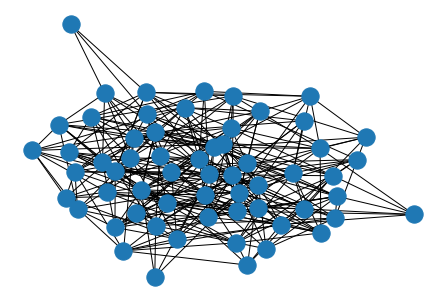

In [5]:
#Generating one graph G to be processed
(D,_),(_,_)=dataset_loading().generate_SBM(Graphs_num=50)
G=D[0]
nx.draw(G)

In [18]:
#Measuring Gaussian RF comp-time
import time 
nodes_num, features_num,samples_num,sigma= range (3,36),500, 1000, 1 #############
sampler_type ="simple_random_sampling"      
GS_time=np.zeros(len(nodes_num)) ####################################################
for (nodes_ind,nodes) in enumerate(nodes_num):
    print('processing k= ', nodes, '\n')
    sampler=graph_sampler(sampler_type,nodes)###########################
    feat_map=Gaussian_random_features(nodes**2,features_num,sigma) ###########################
    (graphlets,_) =sampler.sample(G,samples_num)
    time_st=time.time()
    random_feature=feat_map.transform(graphlets)
    GS_time[nodes_ind]=time.time()-time_st##########################################
np.savetxt("GS_time.csv",GS_time/samples_num,delimiter=',')##################################

processing k=  3 

processing k=  4 

processing k=  5 

processing k=  6 

processing k=  7 

processing k=  8 

processing k=  9 

processing k=  10 

processing k=  11 

processing k=  12 

processing k=  13 

processing k=  14 

processing k=  15 

processing k=  16 

processing k=  17 

processing k=  18 

processing k=  19 

processing k=  20 

processing k=  21 

processing k=  22 

processing k=  23 

processing k=  24 

processing k=  25 

processing k=  26 

processing k=  27 

processing k=  28 

processing k=  29 

processing k=  30 

processing k=  31 

processing k=  32 

processing k=  33 

processing k=  34 

processing k=  35 



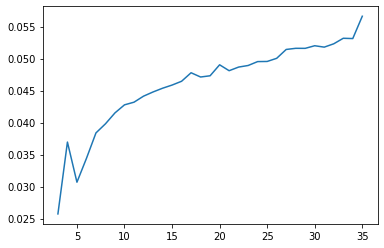

In [19]:
plt.plot(nodes_num,GS_time)

In [22]:
#Measuring Gaussian+ Eigen-values RF comp-time
import time 
nodes_num, features_num,samples_num, sigma= range (3,36),500, 1000, 1 #############
sampler_type,preprocess="simple_random_sampling","Eigen_values"      
EIG_time=np.zeros(len(nodes_num)) ####################################################
for (nodes_ind,nodes) in enumerate(nodes_num):
    print('processing k= ', nodes, '\n')
    sampler=graph_sampler(sampler_type,nodes,preprocess=preprocess)###########################
    feat_map=Gaussian_random_features(nodes,features_num,sigma) ###########################
    (graphlets,EIG_values_time)=sampler.sample(G,samples_num)
    time_st=time.time()
    random_feature=feat_map.transform(graphlets)
    EIG_time[nodes_ind]=time.time()-time_st+EIG_values_time ##########################################
np.savetxt("EIG_time.csv",EIG_time/samples_num,delimiter=',')##################################

processing k=  3 

processing k=  4 

processing k=  5 

processing k=  6 

processing k=  7 

processing k=  8 

processing k=  9 

processing k=  10 

processing k=  11 

processing k=  12 

processing k=  13 

processing k=  14 

processing k=  15 

processing k=  16 

processing k=  17 

processing k=  18 

processing k=  19 

processing k=  20 

processing k=  21 

processing k=  22 

processing k=  23 

processing k=  24 

processing k=  25 

processing k=  26 

processing k=  27 

processing k=  28 

processing k=  29 

processing k=  30 

processing k=  31 

processing k=  32 

processing k=  33 

processing k=  34 

processing k=  35 



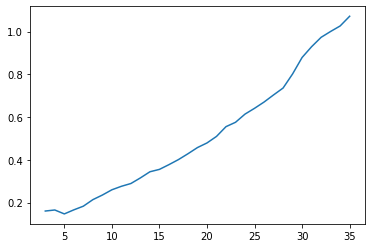

In [23]:
plt.plot(nodes_num,EIG_time)

In [13]:
#Measuring OPU comp-time
import time 
nodes_num, features_num,samples_num= range (3,36),500, 1000 #############
sampler_type ="simple_random_sampling"   
OPU_time=np.zeros(len(nodes_num)) ####################################################
for (nodes_ind,nodes) in enumerate(nodes_num):
    print('processing k= ', nodes, '\n')
    sampler=graph_sampler(sampler_type,nodes)###########################
    feat_map=Lighton_random_features(nodes**2,features_num) ###########################
    (graphlets,_)=sampler.sample(G,samples_num)
    time_st=time.time()
    random_feature=feat_map.transform(graphlets)    
    OPU_time[nodes_ind]=time.time()-time_st##########################################
    feat_map.close()
np.savetxt("OPU_time.csv",OPU_time/samples_num,delimiter=',')##################################

processing k=  3 

processing k=  4 

processing k=  5 

processing k=  6 

processing k=  7 

processing k=  8 

processing k=  9 

processing k=  10 

processing k=  11 

processing k=  12 

processing k=  13 

processing k=  14 

processing k=  15 

processing k=  16 

processing k=  17 

processing k=  18 

processing k=  19 

processing k=  20 

processing k=  21 

processing k=  22 

processing k=  23 

processing k=  24 

processing k=  25 

processing k=  26 

processing k=  27 

processing k=  28 

processing k=  29 

processing k=  30 

processing k=  31 

processing k=  32 

processing k=  33 

processing k=  34 

processing k=  35 



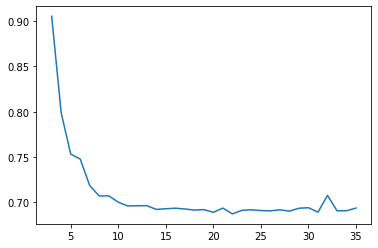

In [14]:
plt.plot(nodes_num,OPU_time)